# 🔰 Project Intro — Tea Leaf Disease Classification (VGG16 Transfer Learning)

>Goal: Build a robust, reproducible pipeline to classify 7 tea leaf conditions from images using transfer learning with VGG16-BN and staged fine tuning.

## 📦 Dataset

* Source: Kaggle — TeaLeafBD (7 classes: Tea algal leaf spot, Brown Blight, Gray Blight, Helopeltis, Red spider, Green mirid bug, Healthy leaf)
* Total images: 5,276 → split into 70% train / 15% val / 15% test
* Citation: Please cite the Kaggle dataset on your report/README.

## 🧪 Approach (What this notebook does)

1. Environment & Storage: Mounts Google Drive, installs deps, sets a persistent project folder.
2. Repo & Data: Clones the training repo, downloads TeaLeafBD from Kaggle, and script-splits into train/val/test.
3. Training Pipeline:
    * Stage-1: Freeze backbone, train classifier head.
    * Stage-2: Unfreeze & fine-tune full model (lower LR).
    * Stage-2-Weighted: Add class weights to handle imbalance.
    * Stage-2-Weighted-Polish: Small LR polish for best generalization.
4. Evaluation & Audit: Saves classification reports, confusion matrices, per-image predictions, t-SNE feature plots, and “most-confident mistakes” gallery.
5. Logging: Each run writes a train_log.csv and best_model.pth for easy comparisons.

## ⚙️ Requirements

* GPU runtime in Colab (Runtime → Change runtime type → GPU)
* kaggle.json API token uploaded (Kaggle → Account → Create New API Token)
* Enough Drive space (~2 GB for dataset + checkpoints)

## ▶️ Quick Start

1. Set GPU & Mount Drive (first cell).
2. Upload kaggle.json when prompted.
3. Run cells in order: clone repo → download dataset → split → train Stage-1 → evaluate → fine-tune stages.
4. Check outputs:
    * Best checkpoints under outputs/<run>/best_model.pth
    * Reports/plots under outputs/<run>/
    * Dataset viz under outputs/dataset_viz/

## 🧾 Deliverables you’ll get

* Best model: outputs/vgg16_stage2_weighted_polish/best_model.pth
* Per-run logs: outputs/*/train_log.csv
* Reports & plots: classification_report.txt, confusion_matrix.png, per-class PRF bars, t-SNE
* Per-image CSVs: per_image_test.csv, per_image_predictions_test.csv (full auditability)

# GPU check
# Mount Drive & set project folder
# Clone repo & inspect structure

In [1]:
# Check GPU
!nvidia-smi -L || true

# Mount Google Drive to persist everything (checkpoints, logs, plots)
from google.colab import drive
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/tea-leaf-vgg16-r21rash"
import pathlib, os, shutil
pathlib.Path(DRIVE_ROOT).mkdir(parents=True, exist_ok=True)
print("Drive folder:", DRIVE_ROOT)


/bin/bash: line 1: nvidia-smi: command not found
Mounted at /content/drive
Drive folder: /content/drive/MyDrive/tea-leaf-vgg16-r21rash




# Install dependencies
# Make repo importable




In [3]:
# Start clean & clone the requested repo
!rm -rf /content/tea-leaf-disease-detection
!git clone https://github.com/R21Rash/tea-leaf-disease-detection.git
%cd /content/tea-leaf-disease-detection
!ls -la

# Try to install requirements if present
!pip -q install --upgrade pip
!pip -q install -r requirements.txt || true
!pip -q install torchvision scikit-learn pyyaml tqdm

# Make the repo importable (search for src/ or a models/ folder)
import sys, os, pathlib, glob
repo = pathlib.Path("/content/tea-leaf-disease-detection")
sys.path.insert(0, str(repo.resolve()))

# If there is a 'src' folder, add it too
src_candidates = [p for p in [repo/"src", repo/"code", repo/"app"] if p.exists()]
for p in src_candidates:
    sys.path.insert(0, str(p.resolve()))
    print("Added to sys.path:", p)

# Show likely model locations to help debug
cands = list(repo.rglob("factory.py")) + list(repo.rglob("vgg16*.py"))
print("Potential model files:", [str(c) for c in cands[:10]])


Cloning into 'tea-leaf-disease-detection'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 73 (delta 21), reused 56 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 3.80 MiB | 8.85 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/tea-leaf-disease-detection
total 44
drwxr-xr-x 6 root root 4096 Oct  9 10:57 .
drwxr-xr-x 1 root root 4096 Oct  9 10:57 ..
drwxr-xr-x 4 root root 4096 Oct  9 10:57 colab
-rw-r--r-- 1 root root  246 Oct  9 10:57 config.yaml
drwxr-xr-x 8 root root 4096 Oct  9 10:57 .git
-rw-r--r-- 1 root root  679 Oct  9 10:57 .gitignore
-rw-r--r-- 1 root root 1066 Oct  9 10:57 LICENSE
-rw-r--r-- 1 root root 2287 Oct  9 10:57 README.md
-rw-r--r-- 1 root root  145 Oct  9 10:57 requirements.txt
drwxr-xr-x 2 root root 4096 Oct  9 10:57 scripts
drwxr-xr-x 3 root root 4096 Oct  9 10:57 src
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s 



# Kaggle authentication




In [4]:
from google.colab import files
print("Upload kaggle.json (Kaggle → Account → Create New API Token)")
files.upload()

import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!pip -q install kaggle
!kaggle datasets list -s tealeafbd | head -n 5


Upload kaggle.json (Kaggle → Account → Create New API Token)


Saving kaggle.json to kaggle.json
ref                                                 title                                        size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------  -------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
bmshahriaalam/tealeafbd-tea-leaf-disease-detection  teaLeafBD: Tea Leaf Disease Detection  1335080720  2025-03-20 16:18:22                   718         10  0.75             
abuhanzala/tea-leaf                                 Tea_LEAF                                735865053  2025-05-08 17:51:32.457000              0          0  0.25             


# Download TeaLeafBD dataset

In [5]:
!mkdir -p datasets
!kaggle datasets download -d bmshahriaalam/tealeafbd-tea-leaf-disease-detection -p datasets
!unzip -q datasets/tealeafbd-tea-leaf-disease-detection.zip -d datasets/tealeafbd
!ls -la datasets/tealeafbd/teaLeafBD/teaLeafBD


Dataset URL: https://www.kaggle.com/datasets/bmshahriaalam/tealeafbd-tea-leaf-disease-detection
License(s): CC-BY-SA-4.0
 97% 1.20G/1.24G [00:11<00:01, 42.6MB/s]
100% 1.24G/1.24G [00:11<00:00, 120MB/s] 
total 272
drwxr-xr-x 9 root root  4096 Oct  9 10:58  .
drwxr-xr-x 3 root root  4096 Oct  9 10:58  ..
drwxr-xr-x 2 root root 28672 Oct  9 10:58 '1. Tea algal leaf spot'
drwxr-xr-x 2 root root 28672 Oct  9 10:58 '2. Brown Blight'
drwxr-xr-x 2 root root 49152 Oct  9 10:58 '3. Gray Blight'
drwxr-xr-x 2 root root 28672 Oct  9 10:58 '4. Helopeltis'
drwxr-xr-x 2 root root 24576 Oct  9 10:58 '5. Red spider'
drwxr-xr-x 2 root root 69632 Oct  9 10:58 '6. Green mirid bug'
drwxr-xr-x 2 root root 36864 Oct  9 10:58 '7. Healthy leaf'


# Patch train.py for CSV logs & AMP

In [6]:
# --- Patch src/train.py: add CSV logging + modern AMP API ---
from pathlib import Path
import re

p = Path("src/train.py")
txt = p.read_text()

# (a) import csv, time if missing
if "import csv" not in txt:
    txt = txt.replace("import argparse, os, time, random",
                      "import argparse, os, time, random\nimport csv")
# pathlib is already imported as Path

# (b) switch deprecated torch.cuda.amp API -> torch.amp
txt = txt.replace("torch.cuda.amp.GradScaler(enabled=args.amp)",
                  "torch.amp.GradScaler('cuda', enabled=args.amp)")
txt = txt.replace("with torch.cuda.amp.autocast():",
                  "with torch.amp.autocast('cuda'):")

# (c) create outdir + CSV header right after args parse
needle = "args = parser.parse_args()"
inject = (
    f"{needle}\n\n"
    "    # === CSV logging setup ===\n"
    "    outdir = Path(args.output_dir); outdir.mkdir(parents=True, exist_ok=True)\n"
    "    log_csv = outdir / 'train_log.csv'\n"
    "    if not log_csv.exists():\n"
    "        with open(log_csv, 'w', newline='') as f:\n"
    "            csv.writer(f).writerow(['epoch','train_loss','train_acc','val_loss','val_acc','lr','time_sec'])\n"
)
txt = txt.replace(needle, inject)

# (d) append a CSV row each epoch (after print)
epoch_print = "print(f\"[{epoch:03d}/{args.epochs}]"
append = (
    "        # === append CSV row ===\n"
    "        with open(log_csv, 'a', newline='') as f:\n"
    "            csv.writer(f).writerow([\n"
    "                epoch, train_loss, train_acc, val_loss, val_acc,\n"
    "                optimizer.param_groups[0]['lr'], round(dt,2)\n"
    "            ])\n"
)
txt = txt.replace(epoch_print, append + epoch_print)

p.write_text(txt)
print("Patched src/train.py ✅")


Patched src/train.py ✅


# Create dataset split script (if missing)

In [7]:
import os, pathlib
pathlib.Path("scripts").mkdir(exist_ok=True)
sp = pathlib.Path("scripts/split_dataset.py")
if not sp.exists():
    sp.write_text("""
import argparse, os, random, shutil
from pathlib import Path
IMG_EXTS={'.jpg','.jpeg','.png','.bmp','.webp'}
def collect_images(root: Path):
    classes, files = [], []
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        classes.append(cls_dir.name)
        for img in cls_dir.rglob('*'):
            if img.suffix.lower() in IMG_EXTS:
                files.append((cls_dir.name, img))
    return classes, files
def split_copy(files, classes, dst: Path, train=0.8, val=0.1, test=0.1, seed=42):
    random.seed(seed)
    by_cls = {c: [] for c in classes}
    for c, p in files: by_cls[c].append(p)
    for c in classes:
        imgs = by_cls[c]; random.shuffle(imgs)
        n = len(imgs); n_tr = int(n*train); n_va = int(n*val)
        parts = {'train': imgs[:n_tr], 'val': imgs[n_tr:n_tr+n_va], 'test': imgs[n_tr+n_va:]}
        for split, items in parts.items():
            outdir = dst / split / c; outdir.mkdir(parents=True, exist_ok=True)
            for src in items: shutil.copy(src, outdir / src.name)
if __name__ == '__main__':
    ap = argparse.ArgumentParser()
    ap.add_argument('--src', required=True)
    ap.add_argument('--dst', default='data')
    ap.add_argument('--train', type=float, default=0.7)
    ap.add_argument('--val', type=float, default=0.15)
    ap.add_argument('--test', type=float, default=0.15)
    ap.add_argument('--seed', type=int, default=42)
    args = ap.parse_args()
    src=Path(args.src); dst=Path(args.dst)
    classes, files = collect_images(src)
    print(f'Found {len(files)} images across {len(classes)} classes: {classes}')
    split_copy(files, classes, dst, train=args.train, val=args.val, test=args.test, seed=args.seed)
    print(f'Done. Structure ready under: {dst}/train|val|test/<class>/')
""")
    print("Created scripts/split_dataset.py")
else:
    print("Using existing scripts/split_dataset.py")


Using existing scripts/split_dataset.py


# Split dataset into train/val/test
# Quick split sanity check

In [8]:
!python scripts/split_dataset.py \
  --src datasets/tealeafbd/teaLeafBD/teaLeafBD \
  --dst data \
  --train 0.7 --val 0.15 --test 0.15

# quick verify
from torchvision import datasets, transforms
import os
for split in ["train","val","test"]:
    root = os.path.join("data", split)
    if not os.path.exists(root):
        continue
    ds = datasets.ImageFolder(root, transform=transforms.ToTensor())
    print(f"[{split}] classes={ds.classes}, count={len(ds)}")


Found 5276 images across 7 classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Done. Structure ready under: data/train|val|test/<class>/
[train] classes=['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf'], count=3690
[val] classes=['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf'], count=788
[test] classes=['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf'], count=798


# Dataset analysis & visuals

,split,class,count,total,percent_of_class
14,test,1. Tea algal leaf spot,64,418,15.311005
0,train,1. Tea algal leaf spot,292,418,69.856459
7,val,1. Tea algal leaf spot,62,418,14.832536
15,test,2. Brown Blight,77,506,15.217391
1,train,2. Brown Blight,354,506,69.960474
8,val,2. Brown Blight,75,506,14.822134
16,test,3. Gray Blight,153,1013,15.103653
2,train,3. Gray Blight,709,1013,69.990128
9,val,3. Gray Blight,151,1013,14.906219
17,test,4. Helopeltis,92,607,15.156507


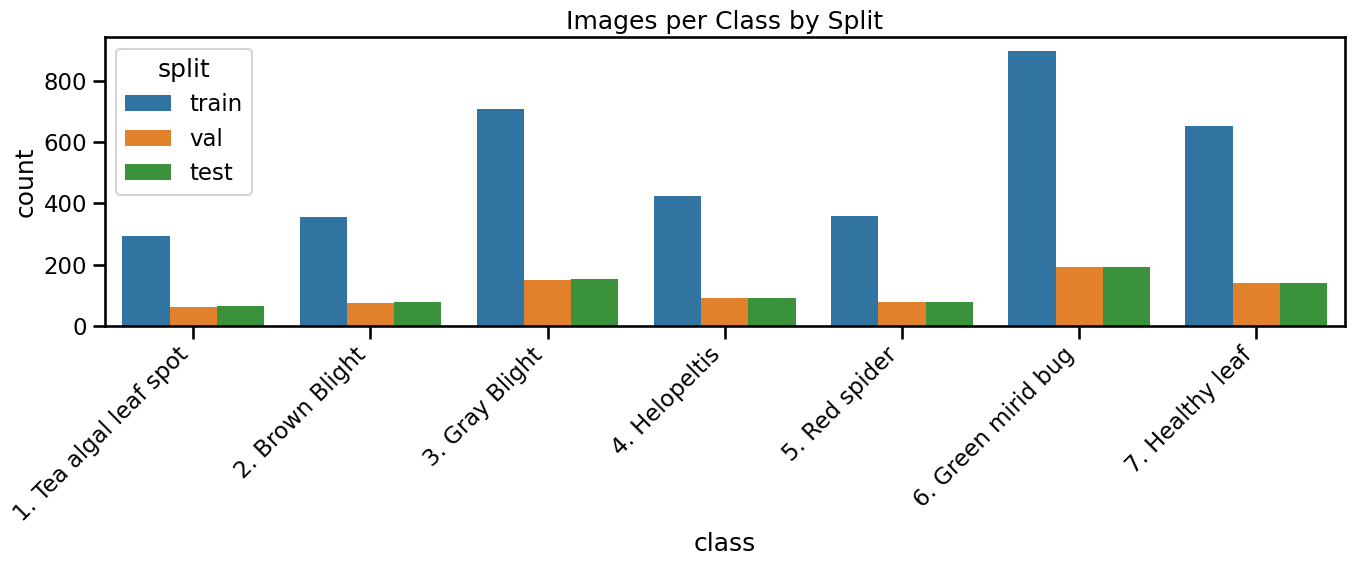

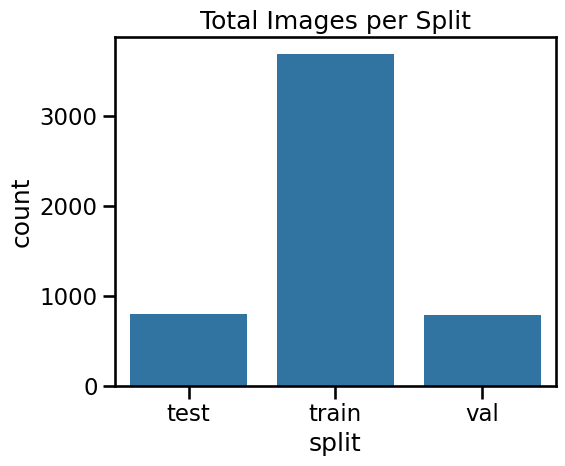

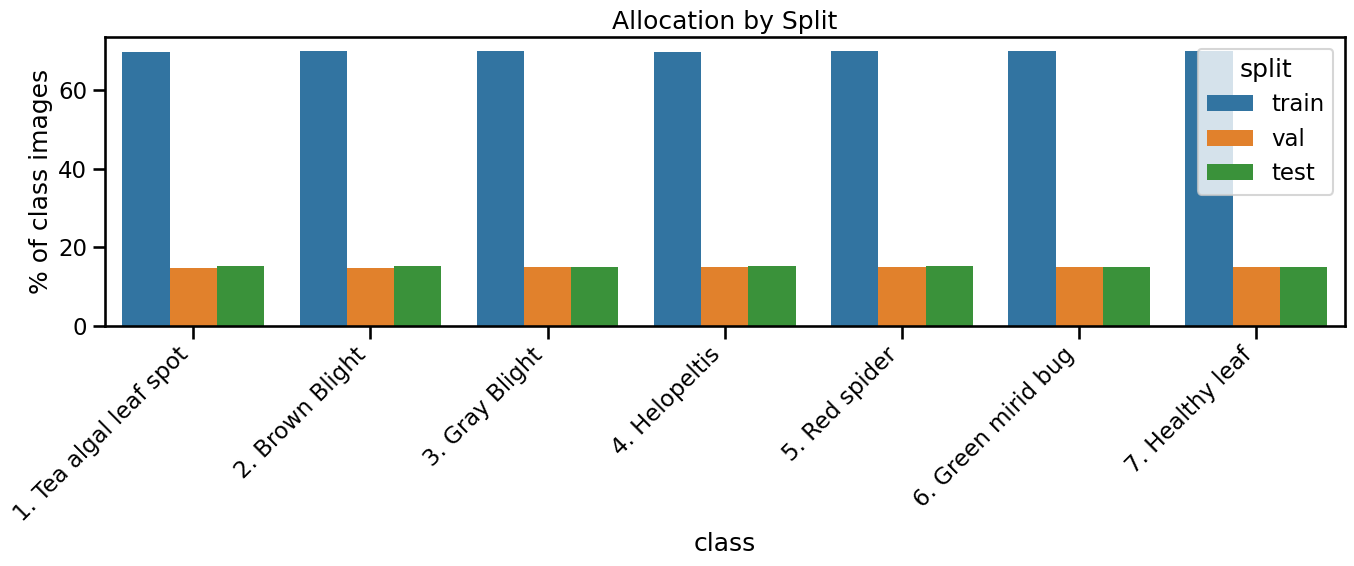

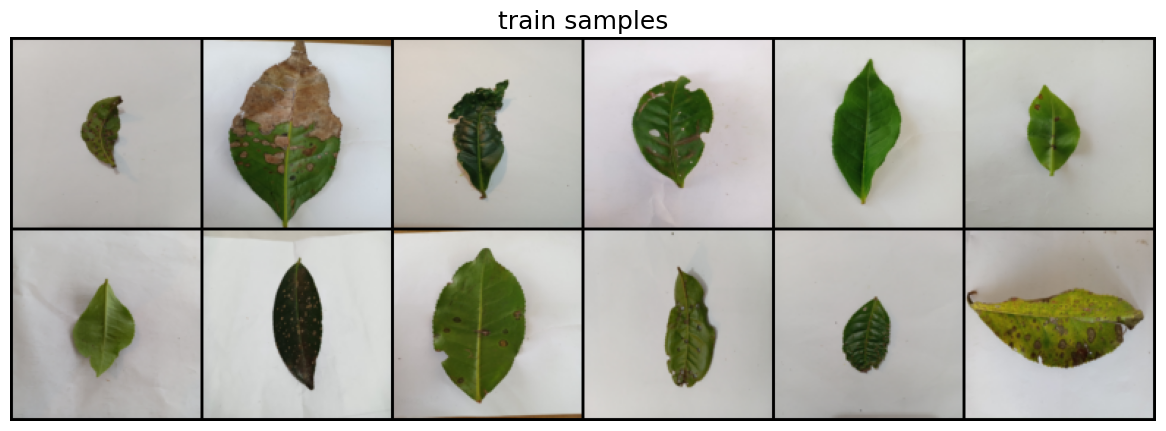

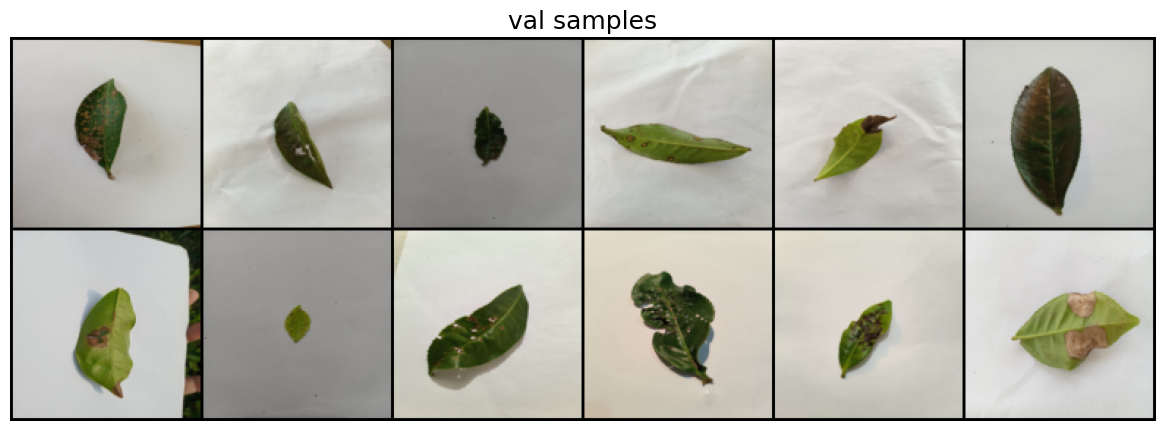

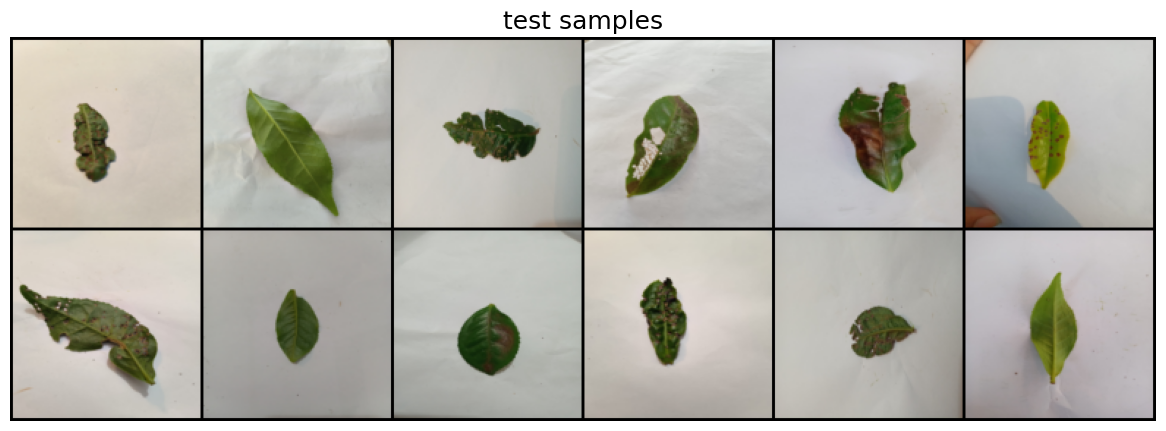

Saved dataset visuals to: /content/drive/MyDrive/tea-leaf-vgg16-r21rash/dataset_viz


In [9]:
import os, random, pathlib, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image

BASE = pathlib.Path("data")
OUTDIR = pathlib.Path("outputs/dataset_viz"); OUTDIR.mkdir(parents=True, exist_ok=True)
splits = [d for d in ["train","val","test"] if (BASE/d).exists()]

# A) Counts table
rows=[]; all_classes=None
for split in splits:
    ds = datasets.ImageFolder(BASE/split)
    if all_classes is None: all_classes = ds.classes
    for cls in all_classes:
        cdir = BASE/split/cls
        n = sum(1 for p in cdir.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"})
        rows.append({"split":split,"class":cls,"count":n})
df = pd.DataFrame(rows)
df["total"] = df.groupby("class")["count"].transform("sum")
df["percent_of_class"] = 100 * df["count"]/df["total"]
display(df.sort_values(["class","split"]))
df.to_csv(OUTDIR/"split_counts.csv", index=False)

# B) Charts
sns.set_context("talk")
plt.figure(figsize=(14,6))
sns.barplot(data=df, x="class", y="count", hue="split")
plt.xticks(rotation=45, ha="right")
plt.title("Images per Class by Split"); plt.tight_layout()
plt.savefig(OUTDIR/"counts_by_class.png", dpi=150); plt.show()

plt.figure(figsize=(6,5))
sns.barplot(data=df.groupby("split")["count"].sum().reset_index(), x="split", y="count")
plt.title("Total Images per Split"); plt.tight_layout()
plt.savefig(OUTDIR/"totals_per_split.png", dpi=150); plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=df, x="class", y="percent_of_class", hue="split")
plt.xticks(rotation=45, ha="right"); plt.ylabel("% of class images")
plt.title("Allocation by Split"); plt.tight_layout()
plt.savefig(OUTDIR/"percent_by_class.png", dpi=150); plt.show()

# C) Sample grids
def sample_paths(root, k=12):
    imgs=[]
    for cls in sorted(os.listdir(root)):
        cdir=os.path.join(root,cls)
        if not os.path.isdir(cdir): continue
        for f in os.listdir(cdir):
            if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                imgs.append(os.path.join(cdir,f))
    random.shuffle(imgs)
    return imgs[:k]

for split in splits:
    paths=sample_paths(str(BASE/split), 12)
    if not paths: continue
    tfm = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
    batch=[]
    for p in paths:
        try: batch.append(tfm(Image.open(p).convert("RGB")))
        except: pass
    if not batch: continue
    grid = make_grid(batch, nrow=6, padding=2).permute(1,2,0).numpy()
    plt.figure(figsize=(12,6)); plt.imshow(np.clip(grid,0,1)); plt.axis('off')
    plt.title(f"{split} samples"); plt.tight_layout()
    plt.savefig(OUTDIR/f"grid_{split}.png", dpi=150); plt.show()

# Copy to Drive
drive_dst = pathlib.Path(DRIVE_ROOT)/"dataset_viz"; drive_dst.mkdir(parents=True, exist_ok=True)
import shutil
for f in OUTDIR.glob("*"): shutil.copy2(f, drive_dst/f.name)
print("Saved dataset visuals to:", drive_dst)


# Stage-1 training (frozen backbone)
Trains VGG16 with the backbone frozen (transfer learning head-only) using AMP; writes train_log.csv and best_model.pth.

In [11]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_stage1 \
  --model vgg16 \
  --img_size 224 \
  --batch_size 32 \
  --epochs 20 \
  --learning_rate 0.003 \
  --freeze_backbone \
  --amp --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100% 528M/528M [00:02<00:00, 186MB/s]
[001/20] 93.6s  train: loss=2.9782 acc=0.3818 | val: loss=0.9907 acc=0.5952
✓ Saved best to outputs/vgg16_stage1/best_model.pth (val_acc=0.5952)
[002/20] 96.6s  train: loss=1.8567 acc=0.5184 | val: loss=1.1885 acc=0.5584
[003/20] 94.2s  train: loss=2.1985 acc=0.5062 | val: loss=1.0676 acc=0.6244
✓ Saved best to outputs/vgg16_stage1/best_model.pth (val_acc=0.6244)
[004/20] 93.4s  train: loss=1.9894 acc=0.4943 | val: loss=1.0213 acc=0.6637
✓ Saved best to outputs/vgg16_stage1/best_model.pth (val_acc=0.6637)
[005/20] 98.0s  train: loss=1.7626 acc=0.5249 | val: loss=1.0643 acc=0.6865
✓ Saved best to outputs/vgg16_stage1/best_model.pth (val_acc=0.6865)
[006/2

# Stage-1 evaluation
Evaluates the best Stage-1 checkpoint on val/test; prints metrics.

In [12]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_eval_stage1 \
  --model vgg16 \
  --evaluate \
  --ckpt outputs/vgg16_stage1/best_model.pth


Using device: cuda
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage1/best_model.pth
Val Loss: 0.7911 | Val Acc: 0.7563
Test Loss: 0.8535 | Test Acc: 0.7168


In [13]:
 import sys, pathlib

# point Python to your repo root and to src/
repo = pathlib.Path("/content/tea-leaf-disease-detection")
sys.path.insert(0, str(repo.resolve()))
sys.path.insert(0, str((repo / "src").resolve()))

# sanity check: where is factory.py?
!ls -la /content/tea-leaf-disease-detection/models || true
!ls -la /content/tea-leaf-disease-detection/src/models || true


ls: cannot access '/content/tea-leaf-disease-detection/models': No such file or directory
total 24
drwxr-xr-x 3 root root 4096 Oct  9 11:02 .
drwxr-xr-x 3 root root 4096 Oct  9 11:02 ..
-rw-r--r-- 1 root root  823 Oct  9 10:57 baseline_cnn.py
-rw-r--r-- 1 root root 1441 Oct  9 10:57 factory.py
drwxr-xr-x 2 root root 4096 Oct  9 11:02 __pycache__
-rw-r--r-- 1 root root 2179 Oct  9 10:57 vgg16.py


# Stage-1 detailed report (confusion & report)

Generates a per-class classification report and a confusion matrix image for the selected split.

                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.7333    0.5156    0.6055        64
       2. Brown Blight     0.5227    0.2987    0.3802        77
        3. Gray Blight     0.5602    0.7908    0.6558       153
         4. Helopeltis     0.7500    0.6848    0.7159        92
         5. Red spider     0.8261    0.4872    0.6129        78
    6. Green mirid bug     0.7328    0.8808    0.8000       193
       7. Healthy leaf     0.9466    0.8794    0.9118       141

              accuracy                         0.7168       798
             macro avg     0.7245    0.6482    0.6689       798
          weighted avg     0.7283    0.7168    0.7080       798

Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage1


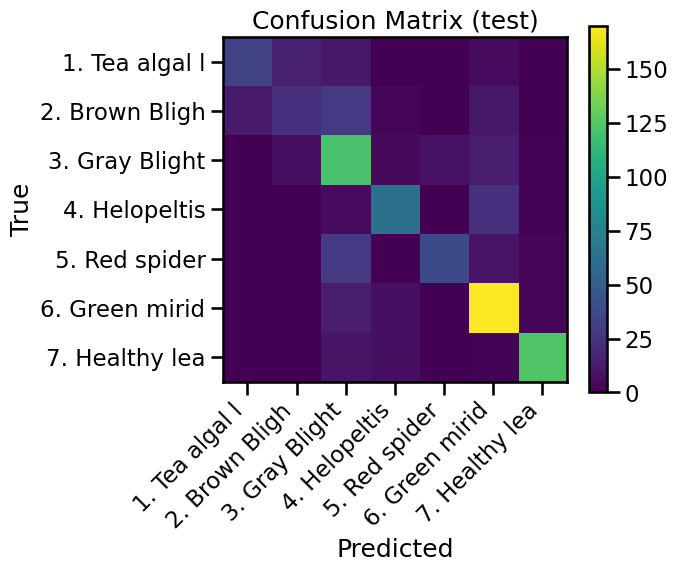

In [14]:
import os, torch, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from models.factory import build_model

DATA_DIR = "data"
CKPT = "outputs/vgg16_stage1/best_model.pth"
IMG_SIZE = 224
BATCH_SIZE = 32

# same normalization as train.py
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Prefer test if present; else use val
test_path = os.path.join(DATA_DIR, "test")
split = "test" if os.path.exists(test_path) and len(os.listdir(test_path))>0 else "val"
ds = datasets.ImageFolder(os.path.join(DATA_DIR, split), transform=val_tfms)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
classes = ds.classes

# build + load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["model"])
model.eval()

all_preds, all_tgts = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_tgts.append(y.numpy())
all_preds = np.concatenate(all_preds); all_tgts = np.concatenate(all_tgts)

# Save report
rep = classification_report(all_tgts, all_preds, target_names=classes, digits=4)
os.makedirs("outputs/vgg16_eval_stage1", exist_ok=True)
with open("outputs/vgg16_eval_stage1/classification_report.txt","w") as f:
    f.write(rep)
print(rep)

# Save confusion matrix image
cm = confusion_matrix(all_tgts, all_preds)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix ({split})"); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [c[:14] for c in classes], rotation=45, ha="right")
plt.yticks(tick_marks, [c[:14] for c in classes])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
fig.savefig("outputs/vgg16_eval_stage1/confusion_matrix.png", dpi=150)
print("Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage1")


# Stage-2 training (fine-tune all layers)

Resumes from a prior checkpoint, unfreezes the backbone, lowers LR, and fine-tunes end-to-end.

In [15]:
# Colab cell
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_stage2 \
  --model vgg16 \
  --epochs 8 \
  --learning_rate 0.0007 \
  --ckpt outputs/vgg16_colab/best_model.pth \
  --amp --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
[001/8] 100.7s  train: loss=1.1743 acc=0.5821 | val: loss=1.3090 acc=0.5660
✓ Saved best to outputs/vgg16_stage2/best_model.pth (val_acc=0.5660)
[002/8] 103.7s  train: loss=0.7977 acc=0.7184 | val: loss=0.9609 acc=0.6992
✓ Saved best to outputs/vgg16_stage2/best_model.pth (val_acc=0.6992)
[003/8] 101.5s  train: loss=0.6736 acc=0.7696 | val: loss=0.5866 acc=0.8071
✓ Saved best to outputs/vgg16_stage2/best_model.pth (val_acc=0.8071)
[004/8] 100.5s  train: loss=0.6151 acc=0.7840 | val: loss=0.7548 acc=0.7690
[005/8] 103.3s  train: loss=0.5989 acc=0.7878 | val: loss=1.4605 acc=0.5990
[006/8] 100.0s  train: loss=0.5099 acc=0.8192 | val: loss=0.4903 acc=0.8236
✓ Saved best to outputs/vgg16_stage2/best_model.pth (val_acc=0.8236)
[007/8] 99.6s  train: loss=0.4815 acc=0.8276 | val: loss=0.5245 acc=0.8376
✓ Saved best to outputs/vg

# Stage-2 evaluation

Evaluates the Stage-2 best checkpoint on val/test and prints final metrics.

In [16]:
 !python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_eval_stage2 \
  --model vgg16 \
  --evaluate \
  --ckpt outputs/vgg16_stage2/best_model.pth \
  --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage2/best_model.pth
Val Loss: 0.4285 | Val Acc: 0.8464
Test Loss: 0.4474 | Test Acc: 0.8509


# Stage-2 detailed report (confusion & report)

Writes a classification report and confusion matrix for Stage-2 results.

                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.6023    0.8281    0.6974        64
       2. Brown Blight     0.7400    0.4805    0.5827        77
        3. Gray Blight     0.8485    0.9150    0.8805       153
         4. Helopeltis     0.7500    0.9783    0.8491        92
         5. Red spider     0.8642    0.8974    0.8805        78
    6. Green mirid bug     0.9933    0.7668    0.8655       193
       7. Healthy leaf     0.9724    1.0000    0.9860       141

              accuracy                         0.8509       798
             macro avg     0.8244    0.8380    0.8202       798
          weighted avg     0.8654    0.8509    0.8485       798

Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2


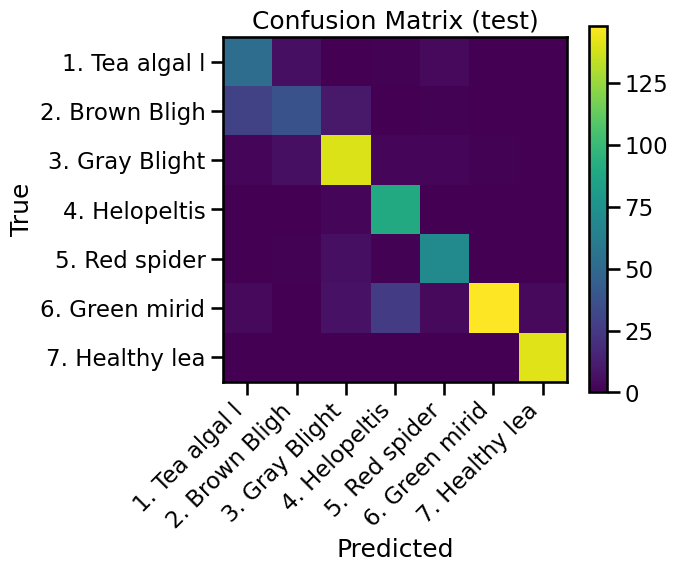

In [17]:
import os, torch, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from models.factory import build_model

DATA_DIR = "data"
CKPT = "outputs/vgg16_stage2/best_model.pth"
IMG_SIZE = 224
BATCH_SIZE = 32

# same normalization as train.py
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Prefer test if present; else use val
test_path = os.path.join(DATA_DIR, "test")
split = "test" if os.path.exists(test_path) and len(os.listdir(test_path))>0 else "val"
ds = datasets.ImageFolder(os.path.join(DATA_DIR, split), transform=val_tfms)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
classes = ds.classes

# build + load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["model"])
model.eval()

all_preds, all_tgts = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_tgts.append(y.numpy())
all_preds = np.concatenate(all_preds); all_tgts = np.concatenate(all_tgts)

# Save report
rep = classification_report(all_tgts, all_preds, target_names=classes, digits=4)
os.makedirs("outputs/vgg16_eval_stage2", exist_ok=True)
with open("outputs/vgg16_eval_stage2/classification_report.txt","w") as f:
    f.write(rep)
print(rep)

# Save confusion matrix image
cm = confusion_matrix(all_tgts, all_preds)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix ({split})"); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [c[:14] for c in classes], rotation=45, ha="right")
plt.yticks(tick_marks, [c[:14] for c in classes])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
fig.savefig("outputs/vgg16_eval_stage2/confusion_matrix.png", dpi=150)
print("Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2")


# Class-weighted fine-tune (short run)

Continues fine-tuning from Stage-2 with smaller LR (and class weighting, if enabled) to address imbalance.

In [18]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_stage2_weighted \
  --model vgg16 \
  --epochs 4 \
  --learning_rate 0.0005 \
  --ckpt outputs/vgg16_stage2/best_model.pth \
  --amp --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage2/best_model.pth
[001/4] 102.5s  train: loss=0.3830 acc=0.8645 | val: loss=0.4348 acc=0.8680
✓ Saved best to outputs/vgg16_stage2_weighted/best_model.pth (val_acc=0.8680)
[002/4] 101.0s  train: loss=0.3510 acc=0.8740 | val: loss=0.3561 acc=0.8718
✓ Saved best to outputs/vgg16_stage2_weighted/best_model.pth (val_acc=0.8718)
[003/4] 101.6s  train: loss=0.3009 acc=0.8986 | val: loss=0.3498 acc=0.8832
✓ Saved best to outputs/vgg16_stage2_weighted/best_model.pth (val_acc=0.8832)
[004/4] 104.8s  train: loss=0.3068 acc=0.8997 | val: loss=0.8403 acc=0.8185
Best Val Acc: 0.8832. Checkpoint: outputs/vgg16_stage2_weighted/best_model.pth


# Class-weighted evaluation

Evaluates the class-weighted checkpoint and saves metrics.

In [19]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_eval_stage2_weighted \
  --model vgg16 \
  --evaluate \
  --ckpt outputs/vgg16_stage2_weighted/best_model.pth \
  --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage2_weighted/best_model.pth
Val Loss: 0.3498 | Val Acc: 0.8832
Test Loss: 0.3896 | Test Acc: 0.8659


# Class-weighted evaluation (confusion & report)

Writes a classification report and confusion matrix for Class-weighted evaluation results.

                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.6122    0.9375    0.7407        64
       2. Brown Blight     0.6154    0.5195    0.5634        77
        3. Gray Blight     0.8841    0.7974    0.8385       153
         4. Helopeltis     0.8462    0.9565    0.8980        92
         5. Red spider     0.9706    0.8462    0.9041        78
    6. Green mirid bug     0.9615    0.9067    0.9333       193
       7. Healthy leaf     0.9790    0.9929    0.9859       141

              accuracy                         0.8659       798
             macro avg     0.8384    0.8510    0.8377       798
          weighted avg     0.8759    0.8659    0.8664       798

Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2_weighted


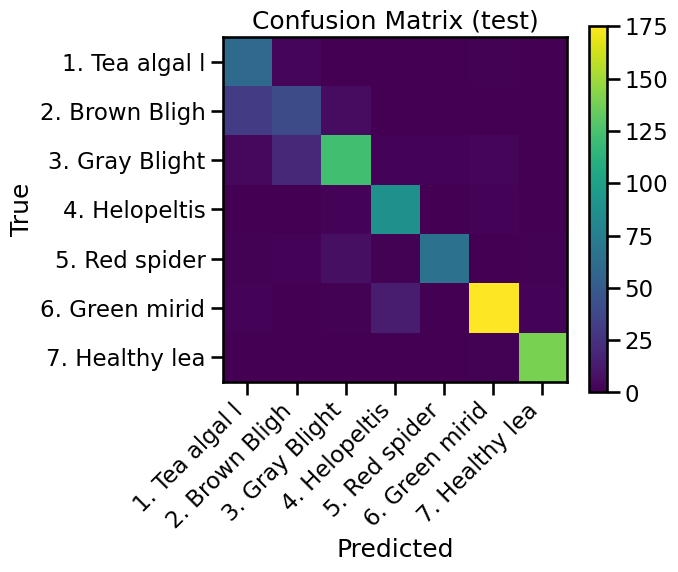

In [20]:
import os, torch, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from models.factory import build_model

DATA_DIR = "data"
CKPT = "outputs/vgg16_stage2_weighted/best_model.pth"
IMG_SIZE = 224
BATCH_SIZE = 32

# same normalization as train.py
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Prefer test if present; else use val
test_path = os.path.join(DATA_DIR, "test")
split = "test" if os.path.exists(test_path) and len(os.listdir(test_path))>0 else "val"
ds = datasets.ImageFolder(os.path.join(DATA_DIR, split), transform=val_tfms)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
classes = ds.classes

# build + load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["model"])
model.eval()

all_preds, all_tgts = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_tgts.append(y.numpy())
all_preds = np.concatenate(all_preds); all_tgts = np.concatenate(all_tgts)

# Save report
rep = classification_report(all_tgts, all_preds, target_names=classes, digits=4)
os.makedirs("outputs/vgg16_eval_stage2_weighted", exist_ok=True)
with open("outputs/vgg16_eval_stage2_weighted/classification_report.txt","w") as f:
    f.write(rep)
print(rep)

# Save confusion matrix image
cm = confusion_matrix(all_tgts, all_preds)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix ({split})"); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [c[:14] for c in classes], rotation=45, ha="right")
plt.yticks(tick_marks, [c[:14] for c in classes])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
fig.savefig("outputs/vgg16_eval_stage2_weighted/confusion_matrix.png", dpi=150)
print("Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2_weighted")


# Polishing fine-tune (smaller LR)

Final short fine-tune with an even smaller LR to stabilize and squeeze extra accuracy.

In [21]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_stage2_weighted_polish \
  --model vgg16 \
  --epochs 6 \
  --learning_rate 0.0003 \
  --ckpt outputs/vgg16_stage2_weighted/best_model.pth \
  --amp --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage2_weighted/best_model.pth
[001/6] 104.3s  train: loss=0.1863 acc=0.9401 | val: loss=0.6098 acc=0.8604
✓ Saved best to outputs/vgg16_stage2_weighted_polish/best_model.pth (val_acc=0.8604)
[002/6] 100.7s  train: loss=0.1440 acc=0.9455 | val: loss=0.4376 acc=0.8909
✓ Saved best to outputs/vgg16_stage2_weighted_polish/best_model.pth (val_acc=0.8909)
[003/6] 100.6s  train: loss=0.1251 acc=0.9534 | val: loss=0.5593 acc=0.8414
[004/6] 104.6s  train: loss=0.2414 acc=0.9157 | val: loss=0.3138 acc=0.8959
✓ Saved best to outputs/vgg16_stage2_weighted_polish/best_model.pth (val_acc=0.8959)
[005/6] 99.4s  train: loss=0.2056 acc=0.9263 | val: loss=0.4223 acc=0.8794
[006/6] 100.4s  train: loss=0.1910 acc=0.9290 | val: loss=0.3815 acc=0.8985
✓ Saved best to outputs/vgg16_stage2_weighted_polish/best_

# Polishing evaluation

Evaluates the polished checkpoint; this is typically your best model.

In [22]:
!python src/train.py \
  --data_dir data \
  --output_dir outputs/vgg16_eval_stage2_weighted_polish \
  --model vgg16 \
  --evaluate \
  --ckpt outputs/vgg16_stage2_weighted_polish/best_model.pth \
  --num_workers 2


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Loading checkpoint: outputs/vgg16_stage2_weighted_polish/best_model.pth
Val Loss: 0.3815 | Val Acc: 0.8985
Test Loss: 0.3610 | Test Acc: 0.9073



# Polishing evaluation (confusion & report)

Writes a classification report and confusion matrix for Polishing evaluation results.

                        precision    recall  f1-score   support

1. Tea algal leaf spot     0.8060    0.8438    0.8244        64
       2. Brown Blight     0.8235    0.7273    0.7724        77
        3. Gray Blight     0.8827    0.9346    0.9079       153
         4. Helopeltis     0.9512    0.8478    0.8966        92
         5. Red spider     0.9589    0.8974    0.9272        78
    6. Green mirid bug     0.9104    0.9482    0.9289       193
       7. Healthy leaf     0.9655    0.9929    0.9790       141

              accuracy                         0.9073       798
             macro avg     0.8998    0.8846    0.8909       798
          weighted avg     0.9075    0.9073    0.9064       798

Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2_weighted_polish


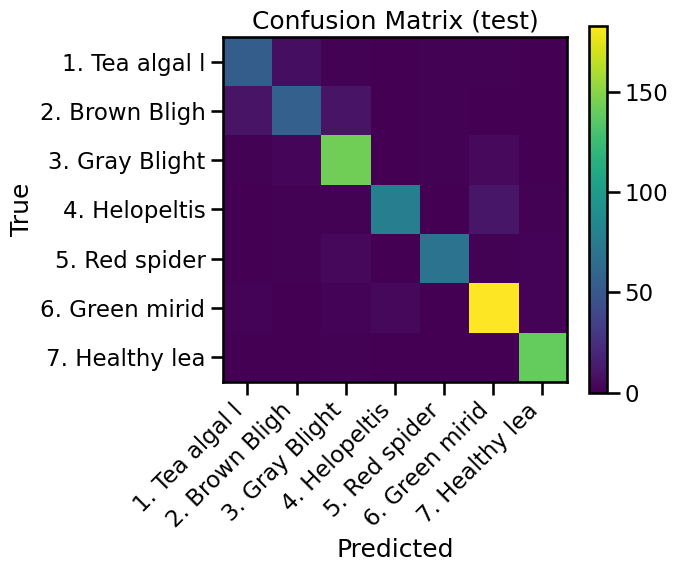

In [23]:
import os, torch, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from models.factory import build_model

DATA_DIR = "data"
CKPT = "outputs/vgg16_stage2_weighted_polish/best_model.pth"
IMG_SIZE = 224
BATCH_SIZE = 32

# same normalization as train.py
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Prefer test if present; else use val
test_path = os.path.join(DATA_DIR, "test")
split = "test" if os.path.exists(test_path) and len(os.listdir(test_path))>0 else "val"
ds = datasets.ImageFolder(os.path.join(DATA_DIR, split), transform=val_tfms)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
classes = ds.classes

# build + load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["model"])
model.eval()

all_preds, all_tgts = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_tgts.append(y.numpy())
all_preds = np.concatenate(all_preds); all_tgts = np.concatenate(all_tgts)

# Save report
rep = classification_report(all_tgts, all_preds, target_names=classes, digits=4)
os.makedirs("outputs/vgg16_eval_stage2_weighted_polish", exist_ok=True)
with open("outputs/vgg16_eval_stage2_weighted_polish/classification_report.txt","w") as f:
    f.write(rep)
print(rep)

# Save confusion matrix image
cm = confusion_matrix(all_tgts, all_preds)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix ({split})"); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [c[:14] for c in classes], rotation=45, ha="right")
plt.yticks(tick_marks, [c[:14] for c in classes])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
fig.savefig("outputs/vgg16_eval_stage2_weighted_polish/confusion_matrix.png", dpi=150)
print("Saved classification_report.txt and confusion_matrix.png to outputs/vgg16_eval_stage2_weighted_polish")


# Aggregate run history (dashboard)

Recursively parses outputs/*/train_log.csv to build a summary table of runs (best val acc, best epoch, time, paths).

In [26]:
import pathlib, pandas as pd, numpy as np

OUT = pathlib.Path("outputs")
logs = []
bad = []

for log in OUT.rglob("train_log.csv"):
    run = log.parent.name
    try:
        df = pd.read_csv(log)
        # sanity checks
        needed = {"epoch","train_loss","train_acc","val_loss","val_acc","time_sec"}
        if df.empty or not needed.issubset(df.columns):
            bad.append((str(log), "empty or missing columns"))
            continue

        # drop rows with NaNs in val_acc
        df = df.dropna(subset=["val_acc"]).reset_index(drop=True)
        if df.empty:
            bad.append((str(log), "val_acc all NaN"))
            continue

        df["run"] = run
        df["epoch_idx"] = range(1, len(df)+1)

        best_idx = int(df["val_acc"].idxmax())
        logs.append({
            "run": run,
            "epochs": int(df["epoch"].max()),
            "best_val_acc": float(df.loc[best_idx, "val_acc"]),
            "best_epoch": int(df.loc[best_idx, "epoch"]),
            "final_train_acc": float(df["train_acc"].iloc[-1]),
            "final_val_acc": float(df["val_acc"].iloc[-1]),
            "total_time_min": round(float(df["time_sec"].sum())/60, 2),
            "csv_path": str(log),
            "best_ckpt": str(log.parent / "best_model.pth"),
        })
    except Exception as e:
        bad.append((str(log), f"read error: {e}"))

if not logs:
    raise FileNotFoundError("No usable train_log.csv files found in outputs/*")

summary = pd.DataFrame(logs).sort_values("best_val_acc", ascending=False).reset_index(drop=True)
print("✔ Valid logs:", len(logs))
if bad:
    print("⚠ Skipped logs:")
    for p, why in bad[:10]:
        print(" -", p, "->", why)
summary


✔ Valid logs: 4
⚠ Skipped logs:
 - outputs/vgg16_eval_stage2_weighted_polish/train_log.csv -> empty or missing columns
 - outputs/vgg16_eval_stage2/train_log.csv -> empty or missing columns
 - outputs/vgg16_eval_stage1/train_log.csv -> empty or missing columns
 - outputs/vgg16_eval_stage2_weighted/train_log.csv -> empty or missing columns


,run,epochs,best_val_acc,best_epoch,final_train_acc,final_val_acc,total_time_min,csv_path,best_ckpt
0,vgg16_stage2_weighted_polish,6,0.898477,6,0.928997,0.898477,10.17,outputs/vgg16_stage2_weighted_polish/train_log...,outputs/vgg16_stage2_weighted_polish/best_mode...
1,vgg16_stage2_weighted,4,0.883249,3,0.899729,0.818528,6.83,outputs/vgg16_stage2_weighted/train_log.csv,outputs/vgg16_stage2_weighted/best_model.pth
2,vgg16_stage2,8,0.846447,8,0.861247,0.846447,13.55,outputs/vgg16_stage2/train_log.csv,outputs/vgg16_stage2/best_model.pth
3,vgg16_stage1,20,0.756345,17,0.610840,0.706853,31.71,outputs/vgg16_stage1/train_log.csv,outputs/vgg16_stage1/best_model.pth


# Per-image predictions + features (one-time base)

Runs inference on every image of a split, saving per-image CSV (true/pred/confidence), and hooks the penultimate layer to cache 4096-D features.

# Per-image predictions (path-aware CSV)

Alternative per-image pass that preserves filepaths and writes per_image_predictions_<split>.csv for easy auditing of mistakes.

In [38]:
# Per-image correctness report on an existing split (train/val/test)
import os, csv, pathlib, torch, numpy as np
from PIL import Image
from torchvision import datasets, transforms
from models.factory import build_model

# --- choose which split & checkpoint ---
SPLIT = "test"           # change to "val" or "train" if you want
DATA_DIR = "data"
CKPT = "outputs/vgg16_stage2_weighted_polish/best_model.pth"  # your best ckpt
IMG_SIZE = 224
BATCH = 32

# --- build dataset (same normalization as training) ---
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

ds = datasets.ImageFolder(os.path.join(DATA_DIR, SPLIT), transform=tfm)
classes = ds.classes# ==== Per-image predictions + feature extraction (one-time base) ====
import os, csv, pathlib, torch, numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.factory import build_model

# --- choose split & checkpoint ---
SPLIT = "test"   # "val" or "train" also OK
DATA_DIR = "data"
CKPT = "outputs/vgg16_stage2_weighted_polish/best_model.pth"  # <- set to your best
IMG_SIZE = 224
BATCH = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms = same as training
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

ds = datasets.ImageFolder(os.path.join(DATA_DIR, SPLIT), transform=tfm)
classes = ds.classes

# Build & load model
state = torch.load(CKPT, map_location=device)
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
model.load_state_dict(state["model"]); model.eval()

# Hook to grab penultimate features (VGG16: classifier[-2] is ReLU before final Linear)
penult_feats = []
def _hook(_mod, _in, out):
    penult_feats.append(out.detach().cpu())

h = model.classifier[-2].register_forward_hook(_hook)

# Inference
rows = []
all_logits = []
with torch.no_grad():
    for path, tgt in ds.samples:
        img = Image.open(path).convert("RGB")
        x = tfm(img).unsqueeze(0).to(device)
        logits = model(x)                 # hook fills penult_feats
        probs  = torch.softmax(logits, 1)[0].cpu().numpy()
        pred   = int(probs.argmax())
        conf   = float(probs[pred])
        rows.append({
            "filepath": os.path.relpath(path, DATA_DIR),
            "true_id": tgt,
            "true_label": classes[tgt],
            "pred_id": pred,
            "pred_label": classes[pred],
            "confidence": conf,
            "correct": int(pred==tgt),
        })
        all_logits.append(logits.cpu())

h.remove()
import numpy as np
feats = torch.cat(penult_feats, dim=0).numpy()     # [N, 4096]
logits = torch.cat(all_logits, dim=0).numpy()       # [N, C]

import pandas as pd
df = pd.DataFrame(rows)
acc = df["correct"].mean()
print(f"{SPLIT} accuracy: {acc:.4f}  ({df['correct'].sum()}/{len(df)})")

# Save CSV alongside checkpoint
out_dir = pathlib.Path(CKPT).parent
csv_path = out_dir / f"per_image_{SPLIT}.csv"
df.to_csv(csv_path, index=False)
print("Wrote:", csv_path)

# Cache for later cells
PRED_BASE = {
    "df": df,
    "classes": classes,
    "feats": feats,
    "logits": logits,
    "split": SPLIT,
    "ckpt_dir": out_dir,
    "data_dir": DATA_DIR,
    "img_size": IMG_SIZE,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- build & load model ---
state = torch.load(CKPT, map_location=device)
model = build_model("vgg16", num_classes=len(classes), img_size=IMG_SIZE, freeze_backbone=False).to(device)
model.load_state_dict(state["model"])
model.eval()

# --- run per-image inference (keeps file paths) ---
rows = []
correct = 0

with torch.no_grad():
    for idx in range(len(ds)):
        path, true_idx = ds.samples[idx]  # (filepath, label_id)
        # load with PIL directly to keep path
        img = Image.open(path).convert("RGB")
        x = tfm(img).unsqueeze(0).to(device)
        probs = torch.softmax(model(x), dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_name, true_name = classes[pred_idx], classes[true_idx]
        conf = float(probs[pred_idx])
        is_correct = int(pred_idx == true_idx)
        correct += is_correct

        rows.append({
            "split": SPLIT,
            "filepath": os.path.relpath(path, start=DATA_DIR),
            "true_label": true_name,
            "pred_label": pred_name,
            "pred_confidence": round(conf, 6),
            "correct": is_correct
        })

acc = correct / len(ds)
print(f"{SPLIT} accuracy on same images: {acc:.4f}  ({correct}/{len(ds)})")

# --- save CSV next to your checkpoint folder ---
out_dir = pathlib.Path(CKPT).parent
csv_path = out_dir / f"per_image_predictions_{SPLIT}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader(); writer.writerows(rows)

print("Wrote:", csv_path)
print("Preview of mistakes:")
for r in rows:
    if not r["correct"]:
        print(f"- {r['filepath']}  GT={r['true_label']}  PRED={r['pred_label']}  p={r['pred_confidence']:.3f}")
        break  # print one; remove break to list all


test accuracy: 0.9073  (724/798)
Wrote: outputs/vgg16_stage2_weighted_polish/per_image_test.csv
test accuracy on same images: 0.9073  (724/798)
Wrote: outputs/vgg16_stage2_weighted_polish/per_image_predictions_test.csv
Preview of mistakes:
- test/1. Tea algal leaf spot/tea_algal_leaf_spot_00019.jpg  GT=1. Tea algal leaf spot  PRED=2. Brown Blight  p=0.756


# Confusion matrix (normalized + counts)

Plots both normalized and raw-count confusion matrices; highlights diagonal counts to visualize class-wise accuracy.

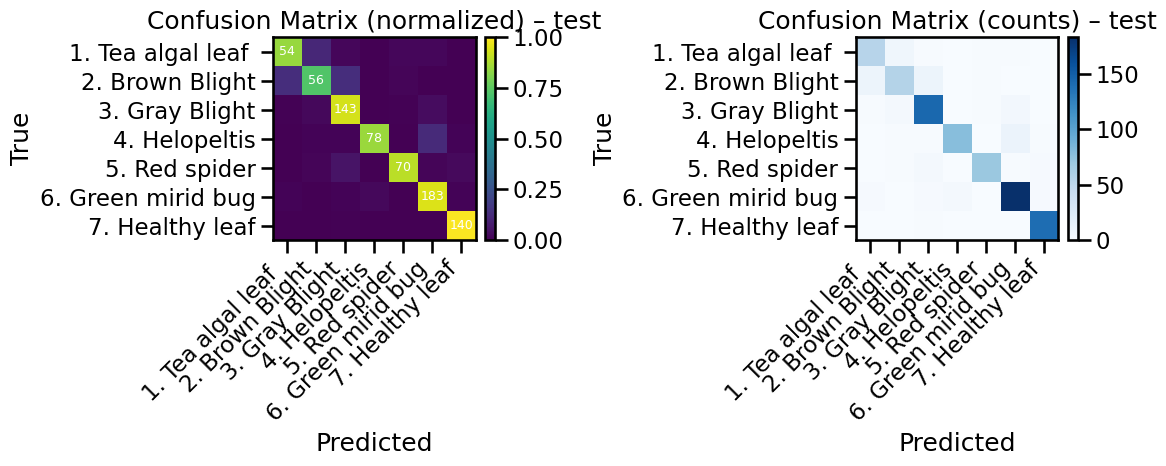

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

df = PRED_BASE["df"]; classes = PRED_BASE["classes"]; split=PRED_BASE["split"]
y_true = df["true_id"].to_numpy()
y_pred = df["pred_id"].to_numpy()

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = (cm.T / cm.sum(axis=1)).T  # row-normalized

fig, ax = plt.subplots(1,2, figsize=(12,5))
im0 = ax[0].imshow(cm_norm, vmin=0, vmax=1)
ax[0].set_title(f"Confusion Matrix (normalized) – {split}")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(classes))); ax[0].set_yticks(range(len(classes)))
ax[0].set_xticklabels([c[:18] for c in classes], rotation=45, ha="right")
ax[0].set_yticklabels([c[:18] for c in classes])
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# annotate diagonals with counts
for i in range(len(classes)):
    ax[0].text(i, i, f"{cm[i,i]}", ha='center', va='center', color='white' if cm_norm[i,i]>.5 else 'black', fontsize=9)

im1 = ax[1].imshow(cm, cmap="Blues")
ax[1].set_title(f"Confusion Matrix (counts) – {split}")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(classes))); ax[1].set_yticks(range(len(classes)))
ax[1].set_xticklabels([c[:18] for c in classes], rotation=45, ha="right")
ax[1].set_yticklabels([c[:18] for c in classes])
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


# Per-class precision/recall/F1

Creates a grouped bar chart from classification_report for a clear class-wise comparison beyond accuracy

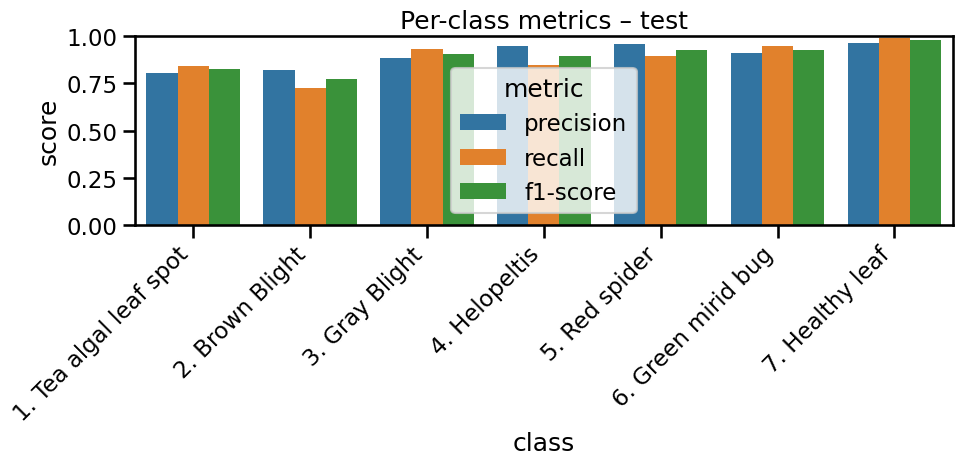

In [40]:
from sklearn.metrics import classification_report
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

report = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
per_class = (pd.DataFrame(report)
             .T.loc[classes, ["precision","recall","f1-score"]]
             .reset_index().rename(columns={"index":"class"}))

plt.figure(figsize=(10,5))
per_class_melt = per_class.melt("class", var_name="metric", value_name="score")
sns.barplot(data=per_class_melt, x="class", y="score", hue="metric")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1.0); plt.title(f"Per-class metrics – {PRED_BASE['split']}")
plt.tight_layout(); plt.show()


# Most-confident mistakes gallery

Shows a grid of the wrong predictions with the highest confidence—useful to find mislabeled or confusing samples.

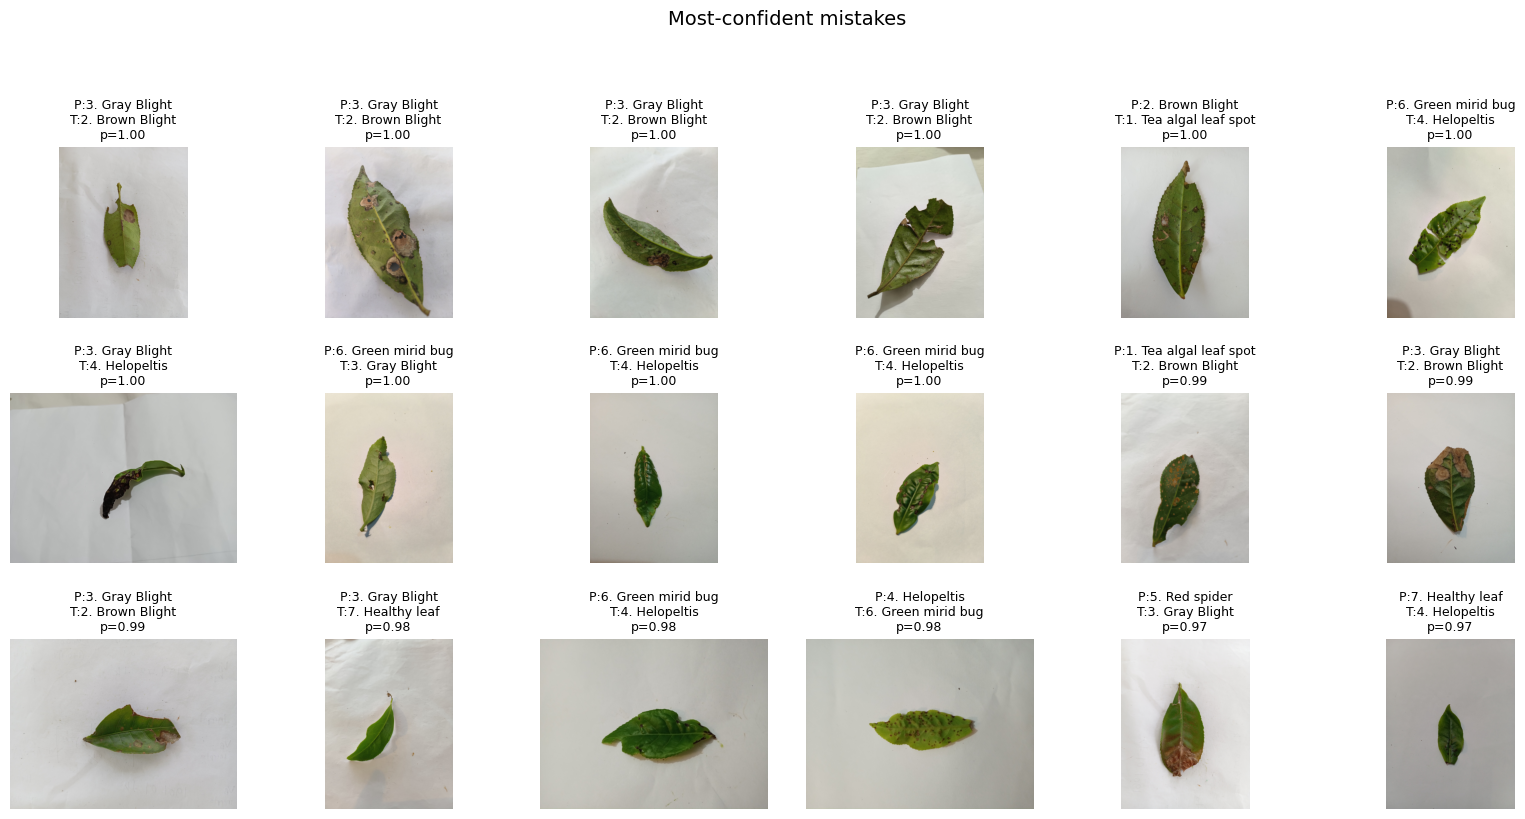

In [41]:
import matplotlib.pyplot as plt
from PIL import Image

df = PRED_BASE["df"]; data_dir=PRED_BASE["data_dir"]
mist = df[df["correct"]==0].sort_values("confidence", ascending=False).head(18)

n = len(mist)
cols = 6
rows = int(np.ceil(n/cols))
plt.figure(figsize=(2.7*cols, 2.7*rows))
for i, row in enumerate(mist.itertuples(), 1):
    path = os.path.join(data_dir, row.filepath)
    img = Image.open(path).convert("RGB")
    plt.subplot(rows, cols, i)
    plt.imshow(img); plt.axis("off")
    title = f"P:{row.pred_label.split('.')[0]}. {row.pred_label.split('. ',1)[-1]}\n" \
            f"T:{row.true_label.split('.')[0]}. {row.true_label.split('. ',1)[-1]}\n" \
            f"p={row.confidence:.2f}"
    plt.title(title, fontsize=9)
plt.suptitle("Most-confident mistakes", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()


# t-SNE of penultimate features

Projects 4096-D features to 2-D with t-SNE to visualize class clusters; misclassified samples are outlined in red.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 798 samples in 0.002s...
[t-SNE] Computed neighbors for 798 samples in 0.396s...
[t-SNE] Computed conditional probabilities for sample 798 / 798
[t-SNE] Mean sigma: 4.960417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.911629
[t-SNE] KL divergence after 1000 iterations: 0.381886


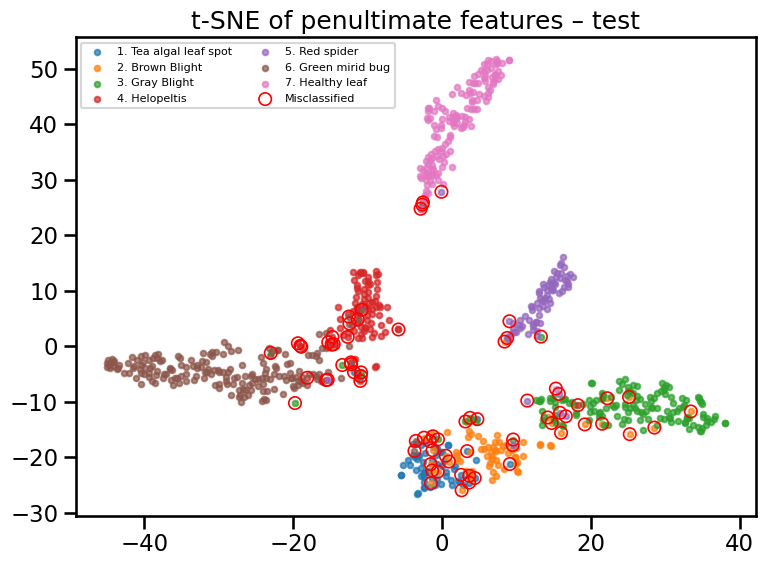

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

feats = PRED_BASE["feats"]            # [N, 4096] penultimate features
labels = y_true
preds  = y_pred
ok = (labels == preds)

# t-SNE (takes ~30–60s on CPU for ~800 pts; set n_iter lower if needed)
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, n_iter=1000, verbose=1)
Z = tsne.fit_transform(feats)

plt.figure(figsize=(8,6))
for cid, cname in enumerate(classes):
    m = labels==cid
    plt.scatter(Z[m,0], Z[m,1], s=16, alpha=0.7, label=cname)

# highlight misclassified with red edge
plt.scatter(Z[~ok,0], Z[~ok,1], s=80, facecolors='none', edgecolors='red', linewidths=1.2, label="Misclassified")

plt.legend(ncol=2, fontsize=8, frameon=True)
plt.title(f"t-SNE of penultimate features – {PRED_BASE['split']}")
plt.tight_layout(); plt.show()


# Top confusions table

For each true class, reports the single most frequent wrong predicted class and its count (compact error summary).

In [43]:
import numpy as np, pandas as pd

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
rows = []
for i, cname in enumerate(classes):
    # exclude correct cell
    row = cm[i].copy()
    row[i] = 0
    if row.sum() == 0:
        rows.append((cname, "-", 0))
        continue
    j = int(np.argmax(row))
    rows.append((cname, classes[j], row[j]))
top_conf = pd.DataFrame(rows, columns=["True class","Most confused with","Count"])
top_conf


,True class,Most confused with,Count
0,1. Tea algal leaf spot,2. Brown Blight,7
1,2. Brown Blight,1. Tea algal leaf spot,10
2,3. Gray Blight,6. Green mirid bug,5
3,4. Helopeltis,6. Green mirid bug,11
4,5. Red spider,3. Gray Blight,4
5,6. Green mirid bug,4. Helopeltis,4
6,7. Healthy leaf,3. Gray Blight,1


#  Training Summary — Tea Leaf Disease Classification (VGG16 Transfer Learning)

## Dataset & Splits


*   Source: Kaggle — TeaLeafBD
*   Classes (7)
      1.   Tea algal leaf spot
      2.   Brown Blight
      1.   Gray Blight
      1.   Helopeltis
      2.   Red spider
      2.   Green mirid bug
      1.   Healthy leaf
*   Total images: 5,276
*   Split: 70% train / 15% val / 15% test
      *   Train: 3,690
      *   Val: 788
      *   Test: 798

##Experimental Setup

*   Backbone: VGG16-BN (ImageNet pre-trained)
*   Input/Batch: 224×224, batch size 32
*   Optimizer: repo default (with AMP enabled)
*   Transforms: torchvision + ImageNet mean/std normalization
*   Strategy: staged transfer learning
      *   Stage-1: freeze backbone, train head (LR 0.003)
      *   Stage-2: unfreeze & fine-tune (LR 0.0007)
      *   Stage-2-Weighted: class-weighted loss (LR 0.0005)
      *   Stage-2-Weighted-Polish: small-LR polish (LR 0.0003)
*   Logging/Artifacts: train_log.csv, best_model.pth, classification reports, confusion matrices, per-image CSVs, t-SNE plots


## Results Overview (Val/Test)

| Run / Checkpoint                                                                           |    Val Acc |   Test Acc | Notes                          |
| ------------------------------------------------------------------------------------------ | ---------: | ---------: | ------------------------------ |
| **Stage-1 (frozen)** — `outputs/vgg16_stage1/best_model.pth`                               | **75.63%** | **71.68%** | Head-only training, LR=0.003   |
| **Stage-2 (fine-tune)** — `outputs/vgg16_stage2/best_model.pth`                            | **84.64%** | **85.09%** | Unfroze backbone, LR=0.0007    |
| **Stage-2-Weighted** — `outputs/vgg16_stage2_weighted/best_model.pth`                      | **88.32%** | **86.59%** | Class-weighted loss, LR=0.0005 |
| **Stage-2-Weighted-Polish (BEST)** — `outputs/vgg16_stage2_weighted_polish/best_model.pth` | **89.85%** | **90.73%** | Final polish, LR=0.0003        |


## Headline Gains

*   Test accuracy: 71.68% → 90.73% (+19.05 pp)
*   Validation accuracy: 75.63% → 89.85% (+14.22 pp)

## Why It Improved

*   Backbone fine-tuning: unlocked ImageNet features for tea-leaf specifics → big jump from Stage-1 to Stage-2.
*   Class weighting: mitigated imbalance → better per-class recall, fewer systematic confusions.
*   Low-LR polish: stabilized late-stage training → best generalization (90.73% test).

## Diagnostic Insights

*   Confusions: notable between Tea algal leaf spot ↔ Brown Blight (similar textures).
*   Per-image audit: best model correctly classified 724 / 798 test images (90.73%); high-confidence mistakes flagged for QA.
*   Feature space (t-SNE): clearer clusters post fine-tune; errors sit near class boundaries.

## Artifacts Produced

*   Best checkpoint: outputs/vgg16_stage2_weighted_polish/best_model.pth
*   Per-run logs: outputs/*/train_log.csv
*   Eval packs: classification_report.txt, confusion_matrix.png
*   Per-image CSVs: per_image_test.csv, per_image_predictions_test.csv
*   Visuals: dataset split charts, confusion matrices (normalized & counts), per-class PRF bars, t-SNE, “most-confident mistakes” gallery

## Accomplishments

*   Reproducible end-to-end pipeline (Drive persistence, Kaggle download, CSV logging, scripted splits).
*   .>90% test accuracy on a 7-class real-world plant disease dataset.
*   Systematic iteration: frozen → fine-tune → class-weighted → polish.
*   Strong explainability & QA via audits and feature-space visualization.






